Pairwise Training:

    Train the model on pairs of teams. For each game, 
you can have a binary outcome: either Team A wins or Team B wins. This can help the model learn the matchups more explicitly.


16
Index(['TEAM_ID', 'Home_Away', 'MATCHUP_ID', 'FG_PCT_DIFF', 'FG3_PCT_DIFF',
       'FT_PCT_DIFF', 'TS%_DIFF', 'eFG%_DIFF', 'AST%_DIFF', 'ORtg_DIFF',
       'PER%_DIFF', 'YEAR', 'MONTH', 'DAY', 'WL_encoded', 'DRtg_Oliver_DIFF'],
      dtype='object')


C:\Users\ghadf\AppData\Local\Temp\ipykernel_40940\2861152730.py:58: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = preprocessor_data.corr()


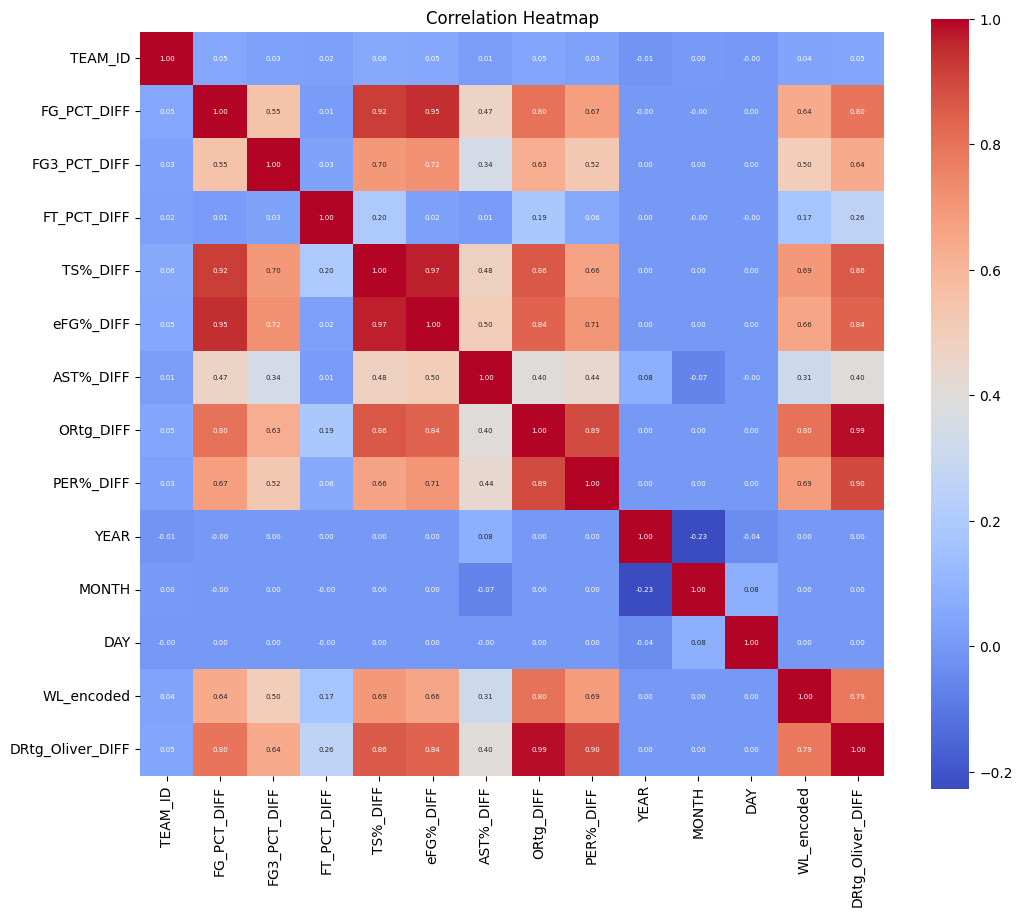

In [1]:
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import StackingClassifier
from sklearn import preprocessing
import mlflow
from mlflow.models import infer_signature
from mlflow.models.evaluation import evaluate
# Load the data
data = pd.read_csv(r'C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\data\nba_threeptera_prepreprocess_data.csv')


# Reorder the columns in the DataFrame to place 'WL_encoded' at the end
preprocessor_data = data[[col for col in data.columns if col != 'WL'] + ['WL']]

#drop the columns that are not needed
x_excluded_independent_variables = [ 'TEAM_ABBREVIATION', 'WL', 'FGA', 'TOV', 'TEAM_NAME', 'GAME_ID', 'PPM', 'RPM', 'APM', 'SPM', 'BPM', 'TPM',   
                                    'FG_PCT', 'FG3_PCT', 'FT_PCT', 'PLUS_MINUS', 'TS%', 'ORtg', 'PER%', 'PTS_PER_MIN', 'eFG%', 'AST%', 'PTS_PER_MIN_DIFF', 'PTS_DIFF',
                                    'PER', 'OPM', 'DPM', 'USG%', 'FG3A', 'OREB', 'PF', 'MIN', 'PTS', 'FGM', 'FG3M', 'FTM', 'FTA', 'PTS', 'REB', 
                                    'AST', 'PF', 'STL', 'BLK', 'DREB', 'Offensive_Possessions', 'SEASON_ID', 'MATCHUP', 'GAME_DATE', #, 
                                    'PTS_OPP', 'FGM_OPP', 'FG3M_OPP', 'FTM_OPP', 'FTA_OPP', 'PTS_OPP', 'REB_OPP', 'OREB_OPP', 'FGA_OPP', 'FG3A_OPP', 'OREB_OPP', 
                                    'AST_OPP', 'TOV_OPP', 'STL_OPP', 'BLK_OPP', 'SEASON_ID_OPP', 'Home_Away_OPP',  'Defensive_Possessions', #
                                     'TEAM_NAME_OPP', 'WL_OPP', 'MIN_OPP', 'PF_OPP', 'DREB_OPP','PTS_PER_MIN_OPP', 'TEAM_ID_OPP',
                                     'FG_PCT_OPP', 'FG3_PCT_OPP', 'FT_PCT_OPP', 'TS%_OPP', 'eFG%_OPP', 'AST%_OPP', 'Defensive_Possessions',
                                    'DRtg', 'DPER%', 'PLUS_MINUS_OPP', 'ORtg_Oliver_OPP', 'ORtg_Oliver_DIFF', 'ORtg_Oliver', 'DRtg_Oliver', 'DRtg_Oliver_OPP'
                                     ]

#drop the columns that are not needed
#preprocessor_data = preprocessor_data.drop(x_excluded_independent_variables, axis=1)

included_columns = ['TEAM_ID', 'Home_Away', 'MATCHUP_ID', 'FG_PCT_DIFF', 'FG3_PCT_DIFF',
       'FT_PCT_DIFF', 'TS%_DIFF', 'eFG%_DIFF', 'AST%_DIFF', 'ORtg_DIFF',
       'PER%_DIFF', 'YEAR', 'MONTH', 'DAY', 'WL_encoded', 'DRtg_Oliver_DIFF']

preprocessor_data = preprocessor_data[included_columns]
print(len(preprocessor_data.columns))
print(preprocessor_data.columns)

# Create a correlation matrix for the selected columns
correlation_matrix = preprocessor_data.corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True,
            annot_kws={'size': 5})  # Adjust the font size (here it's set to 8)


plt.title('Correlation Heatmap')
plt.show()

In [2]:
##UPDATE: because they are identification for the season and team, I would like to update my preprocessor so the variable is updated to ordinal vs non ordinal categorical variables 

# Define the columns for the dependent (y) and independent (X) variables
y_column = 'WL_encoded'


# Combine y_column with x_excluded_independent_variables
columns_to_drop = [y_column] #+ x_excluded_independent_variables

# Define feature lists
categorical_features = [ 'TEAM_ID', 'Home_Away', 'MATCHUP_ID'] #'SEASON_ID', 'MATCHUP', 'TEAM_ID_OPP'
numerical_features = [col for col in preprocessor_data.columns if col not in categorical_features + columns_to_drop]


# Use OrdinalEncoder for the categorical columns
ordinal_encoder = OrdinalEncoder()
#preprocessor_data[categorical_features] = ordinal_encoder.fit_transform(preprocessor_data[categorical_features])

# Fit the encoder on the first dataset's categorical columns
ordinal_encoder.fit(preprocessor_data[categorical_features])

# Transform the first dataset using the fitted encoder in a separate variable
all_encoded = preprocessor_data
all_encoded[categorical_features] = ordinal_encoder.transform(preprocessor_data[categorical_features])
# Convert all_encoded to a pandas DataFrame
all_encoded = pd.DataFrame(all_encoded)
#print(all_encoded.head())
#preprocessor_data[categorical_features] = ordinal_encoder.transform(preprocessor_data[categorical_features])
#print(preprocessor_data.head())


# Define transformers
numerical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent'))
    #,('onehot', OneHotEncoder(handle_unknown='ignore')) # Use OneHotEncoder for non-tree-based models
])

preprocessor = ColumnTransformer([
    ('num', numerical_transformer, numerical_features),
    ('cat', categorical_transformer, categorical_features)
])

# Define X and y
X = all_encoded.drop(columns=columns_to_drop, axis=1)
print('before preprocessing = ', X.shape)
#print(X.head())
y = all_encoded[y_column]
print('y shape = ', y.shape)
# view unique values in the target variable
#print(y.unique())

# Use LabelEncoder to encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

#print(X.isnull().sum())
#print(X.dtypes)
# Preprocess the data
X_preprocessed = preprocessor.fit_transform(X)
print('after preprocessing = ', X_preprocessed.shape)
#print X_preprocessed to see what it looks like
#print(X_preprocessed)

tmp_num = numerical_transformer.fit_transform(X[numerical_features])
print(pd.DataFrame(tmp_num, columns=numerical_features).isnull().sum())

tmp_cat = categorical_transformer.fit_transform(X[categorical_features])
print(pd.DataFrame(tmp_cat).isnull().sum())


before preprocessing =  (13760, 15)
y shape =  (13760,)
after preprocessing =  (13760, 15)
FG_PCT_DIFF         0
FG3_PCT_DIFF        0
FT_PCT_DIFF         0
TS%_DIFF            0
eFG%_DIFF           0
AST%_DIFF           0
ORtg_DIFF           0
PER%_DIFF           0
YEAR                0
MONTH               0
DAY                 0
DRtg_Oliver_DIFF    0
dtype: int64
0    0
1    0
2    0
dtype: int64


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Convert the numpy arrays back to pandas DataFrames
feature_names = preprocessor.transformers_[0][-1] + preprocessor.named_transformers_['cat'].get_feature_names_out().tolist()
print(feature_names)

X_train = pd.DataFrame(X_train, columns=feature_names)
X_test = pd.DataFrame(X_test, columns=feature_names)


# Fit the preprocessor first
preprocessor.fit(X_train)

# Now access the named transformers after fitting
#ohe_feature_names = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
#all_feature_names = np.concatenate([numerical_features, ohe_feature_names])


#print('Original number of features:', len(numerical_features + categorical_features))
#print('Number of features after one-hot encoding:', len(all_feature_names))
#print(ohe_feature_names)
#print(all_feature_names)




['FG_PCT_DIFF', 'FG3_PCT_DIFF', 'FT_PCT_DIFF', 'TS%_DIFF', 'eFG%_DIFF', 'AST%_DIFF', 'ORtg_DIFF', 'PER%_DIFF', 'YEAR', 'MONTH', 'DAY', 'DRtg_Oliver_DIFF', 'TEAM_ID', 'Home_Away', 'MATCHUP_ID']


ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 ['FG_PCT_DIFF', 'FG3_PCT_DIFF', 'FT_PCT_DIFF',
                                  'TS%_DIFF', 'eFG%_DIFF', 'AST%_DIFF',
                                  'ORtg_DIFF', 'PER%_DIFF', 'YEAR', 'MONTH',
                                  'DAY', 'DRtg_Oliver_DIFF']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent'))]),
                                 ['TEAM_ID', 'Home_Away', 'MATCHUP_ID'])])

c:\Users\ghadf\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Model Decision Tree saved to C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\nba_models\decision_tree.joblib
Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.93      0.94      1376
           1       0.93      0.94      0.94      1376

    accuracy                           0.94      2752
   macro avg       0.94      0.94      0.94      2752
weighted avg       0.94      0.94      0.94      2752



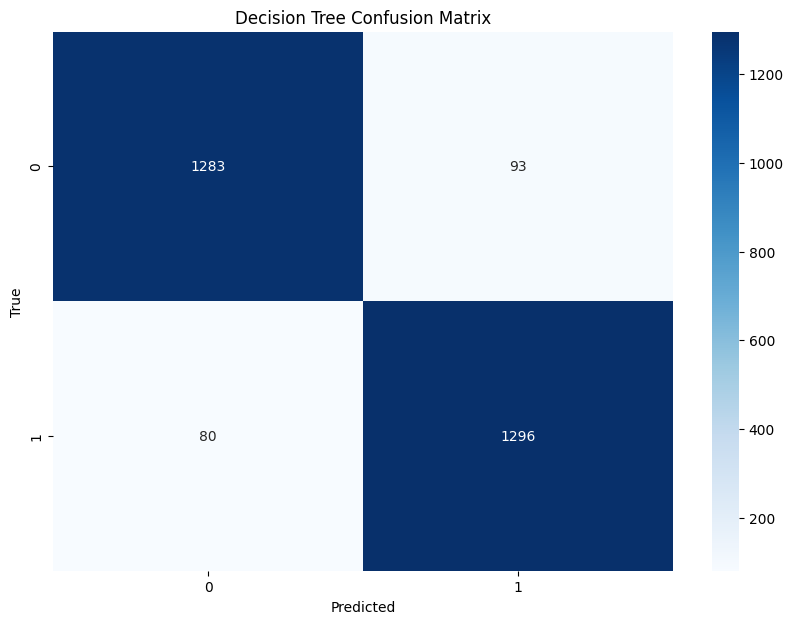

Decision Tree Accuracy: 0.9371
--------------------------------------------------
Model Random Forest saved to C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\nba_models\random_forest.joblib
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      1376
           1       0.96      0.96      0.96      1376

    accuracy                           0.96      2752
   macro avg       0.96      0.96      0.96      2752
weighted avg       0.96      0.96      0.96      2752



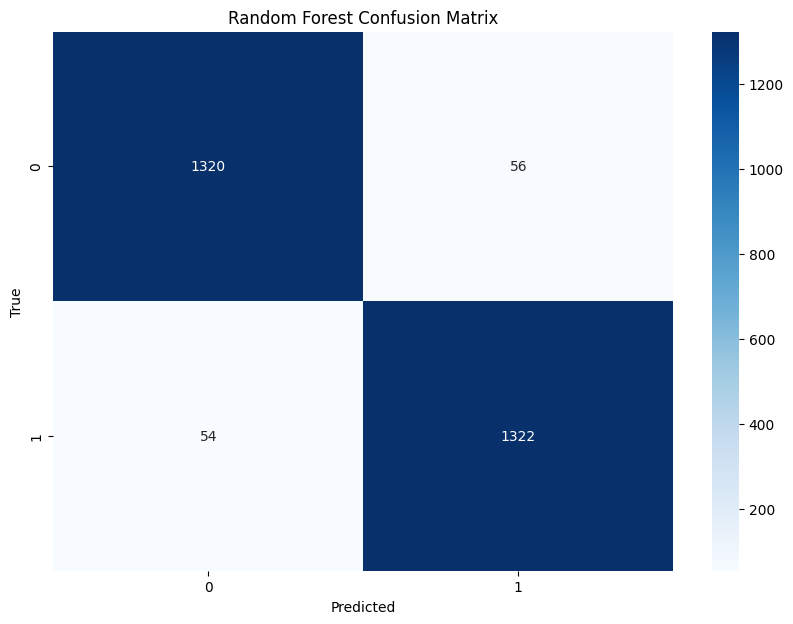

Random Forest Accuracy: 0.9600
--------------------------------------------------
Model Gradient Boosting saved to C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\nba_models\gradient_boosting.joblib
Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      1376
           1       0.96      0.96      0.96      1376

    accuracy                           0.96      2752
   macro avg       0.96      0.96      0.96      2752
weighted avg       0.96      0.96      0.96      2752



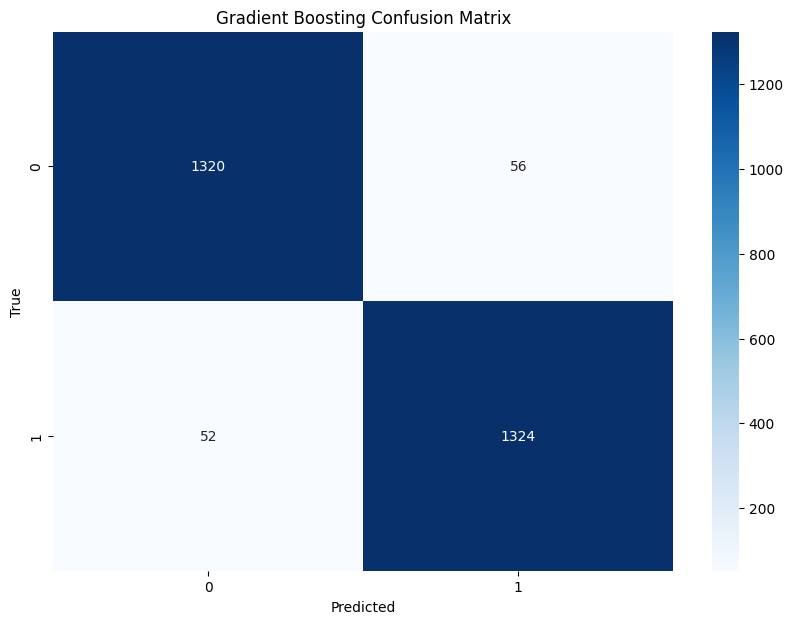

Gradient Boosting Accuracy: 0.9608
--------------------------------------------------
Model AdaBoost saved to C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\nba_models\adaboost.joblib
AdaBoost Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.95      0.96      1376
           1       0.95      0.96      0.96      1376

    accuracy                           0.96      2752
   macro avg       0.96      0.96      0.96      2752
weighted avg       0.96      0.96      0.96      2752



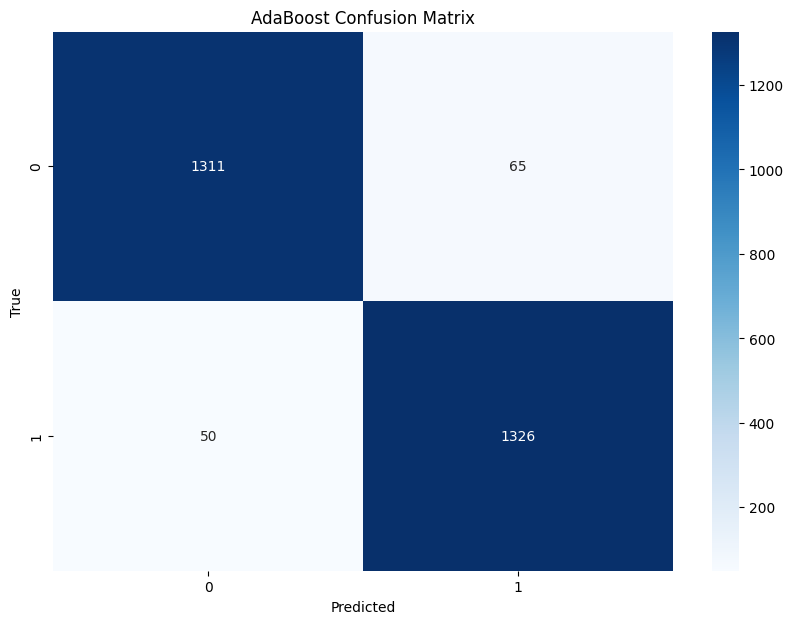

AdaBoost Accuracy: 0.9582
--------------------------------------------------
Model XGBoost saved to C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\nba_models\xgboost.joblib
XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.95      0.96      1376
           1       0.95      0.96      0.96      1376

    accuracy                           0.96      2752
   macro avg       0.96      0.96      0.96      2752
weighted avg       0.96      0.96      0.96      2752



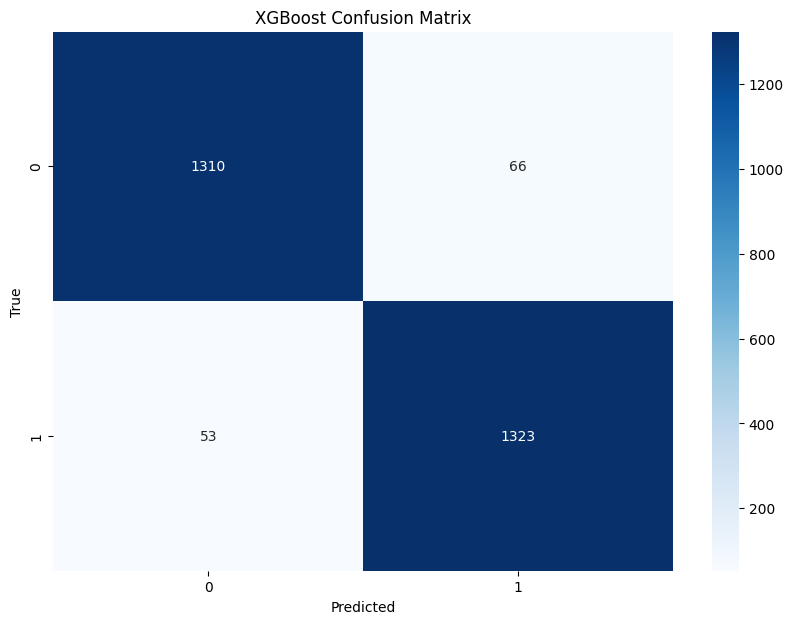

c:\Users\ghadf\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


XGBoost Accuracy: 0.9568
--------------------------------------------------


In [4]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import StackingClassifier
from joblib import dump, load
import os

# Define the path to the directory where you want to save the models
MODEL_DIR = r"C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\nba_models"
if not os.path.exists(MODEL_DIR):
    os.mkdir(MODEL_DIR)
# Define a function to save the models
def save_model(model, name):
    path = os.path.join(MODEL_DIR, f"{name.replace(' ', '_').lower()}.joblib")
    dump(model, path)
    return path


# Count the classes
class_counts = np.bincount(y_encoded)
# Calculate the scale_pos_weight for XGBoost
scale_pos_weight = float(class_counts[0] / class_counts[1])

# Note: Some models have hyperparameters set to avoid potential issues. 
# You should adjust these based on understanding and dataset specifics.

#Bin-classification models
models = [
    ("Logistic Regression", LogisticRegression(max_iter=10000)),
    ("Ridge Classifier", RidgeClassifier()), 
    ("SGD Classifier", SGDClassifier(max_iter=1000, tol=1e-3)),
    ("Decision Tree", DecisionTreeClassifier()), 
    ("Random Forest", RandomForestClassifier(class_weight="balanced")), # Adjusted for imbalance
    ("Gradient Boosting", GradientBoostingClassifier()),
    ("AdaBoost", AdaBoostClassifier()),
    ("SVM", SVC()),
    ("Gaussian Naive Bayes", GaussianNB()),
    ("K-Neighbors Classifier", KNeighborsClassifier()),
    ("XGBoost", XGBClassifier(use_label_encoder=False, eval_metric="logloss", scale_pos_weight=scale_pos_weight)), # Adjusted for imbalance
    ("MLP Classifier", MLPClassifier(max_iter=1000))
]

#split the models into tree and non-tree based models
tree_models = ["XGBoost", "Decision Tree", "Random Forest", "Gradient Boosting", "AdaBoost"]
non_tree_models = ["Logistic Regression", "Ridge Classifier", "SGD Classifier", "SVM", "Gaussian Naive Bayes", "K-Neighbors Classifier", "MLP Classifier"]

#filter the models variable to only include tree-based models
models = [model for model in models if model[0] in tree_models]

# filter the models variable to only include non-tree-based models
#models = [model for model in models if model[0] in non_tree_models]
#print(models)

num_classes = len(np.unique(y_encoded))

#Multi-classification models
#models = [
#    ("Logistic Regression", LogisticRegression(multi_class='ovr', max_iter=10000)),
#    ("Ridge Classifier", RidgeClassifier()), 
#    ("SGD Classifier", SGDClassifier(max_iter=1000, tol=1e-3)),
#    ("Decision Tree", DecisionTreeClassifier()), 
#    ("Random Forest", RandomForestClassifier(class_weight="balanced")), # Adjusted for imbalance
#    ("Gradient Boosting", GradientBoostingClassifier()),
#    ("AdaBoost", AdaBoostClassifier(algorithm='SAMME')),
#    ("SVM", SVC(probability=True)), # Added probability=True for decision boundary plotting
#    ("Gaussian Naive Bayes", GaussianNB()),
#    ("K-Neighbors Classifier", KNeighborsClassifier()),
#    ("XGBoost", XGBClassifier(use_label_encoder=False, 
#                              eval_metric="mlogloss", 
#                              objective="multi:softprob", 
#                              num_class=num_classes)), 
#    ("MLP Classifier", MLPClassifier(max_iter=1000))
#]


def plot_decision_boundary(pred_func, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)


def display_confusion_matrix(classifier, X_test, y_test):
    matrix = confusion_matrix(y_test, classifier.predict(X_test), labels=classifier.classes_)
    plt.figure(figsize=(10, 7))
    sns.heatmap(matrix, annot=True, fmt="d",
                xticklabels=classifier.classes_,
                yticklabels=classifier.classes_, cmap=plt.cm.Blues)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f"{name} Confusion Matrix")
    plt.show()

from sklearn.decomposition import PCA

from sklearn.base import clone

# Continue using your PCA as before
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Train models, plot decision boundaries, and display confusion matrices
results = []
for name, model in models:
    model.fit(X_train, y_train)  # Training on original data
    y_pred = model.predict(X_test)  # Predicting on original data
    
    # Save the trained model
    saved_path = save_model(model, name)
    print(f"Model {name} saved to {saved_path}")
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    results.append((name, accuracy))
    
    # Display classification report
    report = classification_report(y_test, y_pred)
    print(f"{name} Classification Report:")
    print(report)
    
    # Display confusion matrix (using the original X_test)
    display_confusion_matrix(model, X_test, y_test)  
    
    # Now for the decision boundary, we need to train the model again on PCA data.
    # Clone the model to avoid refitting the original one
    model_clone = clone(model)
    model_clone.fit(X_train_pca, y_train)
    
    # Plot decision boundaries using the model trained on PCA data
    #plt.figure(figsize=(10,6))
    #plot_decision_boundary(lambda x: model_clone.predict(x), X_train_pca, y_train)
    #plt.title(name)
    #plt.show()
    
    print(f"{name} Accuracy: {accuracy:.4f}")
    print("--------------------------------------------------")



In [5]:
# Fit the encoder on the first dataset's categorical columns
ordinal_encoder.fit(data[categorical_features])
#print(ordinal_encoder.categories_)
print(data[categorical_features].head())

#save the ordinal_encoder, label_encoder, and preprocessor to C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\preprocessing


MODEL_DIR = r"C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\preprocessing"
saved_path = save_model(preprocessor, 'tree_preprocessor')
saved_path = save_model(label_encoder, 'label_encoder')
saved_path = save_model(ordinal_encoder, 'ordinal_encoder')
print(f"Model saved to {saved_path}")

      TEAM_ID Home_Away MATCHUP_ID
0  1610612737      Away     ATLNOP
1  1610612737      Home     ATLWAS
2  1610612737      Home     ATLMIN
3  1610612737      Away     ATLMIL
4  1610612737      Home     ATLNYK
Model saved to C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\preprocessing\ordinal_encoder.joblib


In [6]:
#read "unseen" data so we can test what these models would predict for the 2022 playoffs
#prediction_data = pd.read_csv(r'C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\data\nba_test_unseen_dataset.csv')
prediction_data = pd.read_csv(r'C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\data\23_24_season_games_clean.csv')

#print(prediction_data.head())

# Drop the columns that are not needed Matchup
prediction_data = prediction_data.drop(columns=['PTS_PER_MIN', 'PTS_DIFF', 'PTS_PER_MIN_DIFF','FG_PCT', 'FG3_PCT', 'FT_PCT', 'PLUS_MINUS', 'TS%', 'ORtg', 'PER%', 'eFG%', 'AST%', ])
    
included_columns = ['TEAM_ID', 'Home_Away', 'MATCHUP_ID', 'FG_PCT_DIFF', 'FG3_PCT_DIFF',
       'FT_PCT_DIFF', 'TS%_DIFF', 'eFG%_DIFF', 'AST%_DIFF', 'ORtg_DIFF',
       'PER%_DIFF', 'YEAR', 'MONTH', 'DAY', 'WL_encoded', 'DRtg_Oliver_DIFF']



feature_order = [#'PTS_PER_MIN', 'PTS_DIFF', 'PTS_PER_MIN_DIFF', 'TEAM_ID_OPP', 'FG_PCT', 'FG3_PCT', 'FT_PCT', 'PLUS_MINUS',  'FG_PCT_OPP', 'FG3_PCT_OPP',  'SEASON_ID', 'GAME_ID'
                   #'TS%', 'ORtg', 'PER%', 'eFG%', 'AST%', 'FT_PCT_OPP', 'PLUS_MINUS_OPP','TS%_OPP', 'eFG%_OPP', 'AST%_OPP', , 'MATCHUP'
                  'Home_Away', 'YEAR', 'MONTH', 'DAY', 'MATCHUP_ID','TEAM_ID', #'DRtg', 'DPER%',
                 'FG_PCT_DIFF','FG3_PCT_DIFF','FT_PCT_DIFF','TS%_DIFF','eFG%_DIFF','AST%_DIFF','ORtg_DIFF','PER%_DIFF', 'DRtg_Oliver_DIFF'] #, 'MATCHUP'

prediction_data = prediction_data[included_columns]
#prediction_data = prediction_data.drop(x_excluded_independent_variables, axis=1)

#does feature_names = feature_order?
print(len(included_columns))
print(len(feature_order))

# Reorder columns in the new_data DataFrame
prediction_data = prediction_data[feature_order]
print(prediction_data.head())
print(prediction_data.shape)

16
15
  Home_Away  YEAR  MONTH  DAY MATCHUP_ID     TEAM_ID  FG_PCT_DIFF  \
0      Away  2023     11    6     LALMIA  1610612747    -0.005360   
1      Home  2023     11    6     LACNYK  1610612752     0.000570   
2      Home  2023     11    6     LALMIA  1610612748    -0.010938   
3      Home  2023     11    6     BKNMIL  1610612751    -0.017664   
4      Away  2023     11    6     LACNYK  1610612746    -0.006130   

   FG3_PCT_DIFF  FT_PCT_DIFF  TS%_DIFF  eFG%_DIFF  AST%_DIFF  ORtg_DIFF  \
0      0.006166     0.031498  0.001326   0.000475   0.290511   1.538754   
1     -0.003742     0.012674  0.005579   0.005437   2.203340  -0.158631   
2     -0.016563    -0.014340 -0.011616  -0.009598  -1.316818  -3.283883   
3     -0.012608    -0.005964 -0.025971  -0.024239  -3.089368  -2.212345   
4     -0.021825    -0.024148 -0.013878  -0.010328   0.296588  -0.620225   

   PER%_DIFF  DRtg_Oliver_DIFF  
0   3.217079          2.033557  
1   0.171344         -0.029469  
2  -4.058265         -3.11148

In [7]:
assert set(feature_order) == set(prediction_data.columns)


In [8]:
#############################################################################################################

#load the encoder from C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\nba_models
ordinal_encoder = load(r'C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\preprocessing\ordinal_encoder.joblib')

# Fit the encoder on the first dataset's categorical columns
ordinal_encoder.fit(data[categorical_features])

#save the encoder to C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\nba_models
saved_path = save_model(ordinal_encoder, 'ordinal_encoder')
print(f"Model saved to {saved_path}")

# Transform the categorical columns in dataset1 using the fitted encoder
#print(data.head())
#preprocessor_data[categorical_features] = ordinal_encoder.transform(preprocessor_data[categorical_features])
#print(preprocessor_data.head())

print(prediction_data.head())
# Use OrdinalEncoder for the categorical columns
prediction_data[categorical_features] = ordinal_encoder.transform(prediction_data[categorical_features])
print(prediction_data.head())

# Check if the categorical columns in dataset1 and dataset2 are the same
if set(prediction_data[categorical_features]) != set(preprocessor_data[categorical_features]):
    raise ValueError("Categorical columns in dataset1 do not match dataset2")



Model saved to C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\preprocessing\ordinal_encoder.joblib
  Home_Away  YEAR  MONTH  DAY MATCHUP_ID     TEAM_ID  FG_PCT_DIFF  \
0      Away  2023     11    6     LALMIA  1610612747    -0.005360   
1      Home  2023     11    6     LACNYK  1610612752     0.000570   
2      Home  2023     11    6     LALMIA  1610612748    -0.010938   
3      Home  2023     11    6     BKNMIL  1610612751    -0.017664   
4      Away  2023     11    6     LACNYK  1610612746    -0.006130   

   FG3_PCT_DIFF  FT_PCT_DIFF  TS%_DIFF  eFG%_DIFF  AST%_DIFF  ORtg_DIFF  \
0      0.006166     0.031498  0.001326   0.000475   0.290511   1.538754   
1     -0.003742     0.012674  0.005579   0.005437   2.203340  -0.158631   
2     -0.016563    -0.014340 -0.011616  -0.009598  -1.316818  -3.283883   
3     -0.012608    -0.005964 -0.025971  -0.024239  -3.089368  -2.212345   
4     -0.021825    -0.024148 -0.013878  -0.010328   0.296588  

In [9]:
#check for these team_id's in the prediction_data [1610612737, 1610612738, 1610612739, 1610612740, 1610612741, 1610612742, 1610612743, 1610612744, 1610612745, 1610612746, 1610612747, 1610612748, 1610612749, 1610612750, 1610612751, 1610612752, 1610612753, 1610612754, 1610612755, 1610612756, 1610612757, 1610612758, 1610612759, 1610612760, 1610612761, 1610612762, 1610612763, 1610612764, 1610612765, 1610612766]
prediction_teams = prediction_data['TEAM_ID'].unique()
print(prediction_teams)

# Fit the encoder on the first dataset's categorical columns
#ordinal_encoder.fit(preprocessor_data[categorical_features])

# Use OrdinalEncoder for the categorical columns
#prediction_data[categorical_features] = ordinal_encoder.transform(prediction_data[categorical_features])

print(prediction_data.head())



[10. 15. 11. 14.  9.  1. 12. 18. 16. 17. 28. 27.  5. 22.  7.  0.  4.  8.
 25.  6. 21. 23. 13.  3.]
   Home_Away  YEAR  MONTH  DAY  MATCHUP_ID  TEAM_ID  FG_PCT_DIFF  \
0        0.0  2023     11    6       300.0     10.0    -0.005360   
1        1.0  2023     11    6       288.0     15.0     0.000570   
2        1.0  2023     11    6       300.0     11.0    -0.010938   
3        1.0  2023     11    6        43.0     14.0    -0.017664   
4        0.0  2023     11    6       288.0      9.0    -0.006130   

   FG3_PCT_DIFF  FT_PCT_DIFF  TS%_DIFF  eFG%_DIFF  AST%_DIFF  ORtg_DIFF  \
0      0.006166     0.031498  0.001326   0.000475   0.290511   1.538754   
1     -0.003742     0.012674  0.005579   0.005437   2.203340  -0.158631   
2     -0.016563    -0.014340 -0.011616  -0.009598  -1.316818  -3.283883   
3     -0.012608    -0.005964 -0.025971  -0.024239  -3.089368  -2.212345   
4     -0.021825    -0.024148 -0.013878  -0.010328   0.296588  -0.620225   

   PER%_DIFF  DRtg_Oliver_DIFF  
0   3.21

In [10]:
#load in preprocessing from C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\nba_models
preprocessor = load(r'C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\preprocessing\tree_preprocessor.joblib')

# Preprocess X_new
X_new_preprocessed = preprocessor.transform(prediction_data)
print(X_new_preprocessed.shape)
#print(X_new_preprocessed)
X_unseen_preprocessed = pd.DataFrame(X_new_preprocessed, columns=feature_names)
print(X_unseen_preprocessed.head())


(24, 15)
   FG_PCT_DIFF  FG3_PCT_DIFF  FT_PCT_DIFF  TS%_DIFF  eFG%_DIFF  AST%_DIFF  \
0    -0.008194      0.010252     0.030253  0.000044  -0.001548   0.290543   
1    -0.002270      0.000349     0.011394  0.004291   0.003407   2.199583   
2    -0.013765     -0.012464    -0.015670 -0.012880  -0.011609  -1.313603   
3    -0.020483     -0.008511    -0.007278 -0.027215  -0.026233  -3.082642   
4    -0.008963     -0.017723    -0.025496 -0.015139  -0.012339   0.296608   

   ORtg_DIFF  PER%_DIFF         YEAR      MONTH       DAY  DRtg_Oliver_DIFF  \
0   1.539861   3.224220  2022.562785  10.975028  6.011159          2.035225   
1  -0.160690   0.166982  2022.562785  10.975028  6.011159         -0.032370   
2  -3.291771  -4.078603  2022.562785  10.975028  6.011159         -3.121211   
3  -2.218235  -1.501851  2022.562785  10.975028  6.011159         -2.018213   
4  -0.623145   2.798991  2022.562785  10.975028  6.011159         -0.973459   

   TEAM_ID  Home_Away  MATCHUP_ID  
0     10.0       

In [11]:
# Load the trained Random Forest model
MODEL_DIR = r"C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\nba_models"
xgboost = os.path.join(MODEL_DIR, "xgboost.joblib")
trained_rf = load(xgboost)

#original_feature_order = ['FG_PCT', 'FG3_PCT', 'FT_PCT', 'PLUS_MINUS', 'TS%', 'ORtg', 'PER%', 'PTS_PER_MIN', 'eFG%', 'AST%', 'FG_PCT_DIFF', 'FG3_PCT_DIFF', 'FT_PCT_DIFF', 'TS%_DIFF', 'eFG%_DIFF', 'AST%_DIFF', 'ORtg_DIFF', 'PER%_DIFF', 'PTS_DIFF', 'PTS_PER_MIN_DIFF', 'YEAR', 'MONTH', 'DAY', 'TEAM_ID', 'TEAM_ID_OPP', 'Home_Away', 'MATCHUP_ID']
#X_unseen_preprocessed = X_unseen_preprocessed[original_feature_order]

# Predict using the trained model
predictions_rf = trained_rf.predict(X_unseen_preprocessed)

# Convert predictions back from encoded form to original labels
decoded_predictions_rf = label_encoder.inverse_transform(predictions_rf)

# Add predictions as a new column to the original dataframe
prediction_data['PREDICTION'] = decoded_predictions_rf

# Inverse transform the encoded categorical columns back to their original form
prediction_data[categorical_features] = ordinal_encoder.inverse_transform(prediction_data[categorical_features])

# Display the results with the original values
#print(prediction_data.head())

# put YEAR, MONTH, DAY into a date column
prediction_data['Date'] = pd.to_datetime(prediction_data[['YEAR', 'MONTH', 'DAY']])
#sort by date
prediction_data = prediction_data.sort_values(by=['Date'])
print(prediction_data.head())

   Home_Away  YEAR  MONTH  DAY MATCHUP_ID     TEAM_ID  FG_PCT_DIFF  \
0       Away  2023     11    6     LALMIA  1610612747    -0.005360   
21      Home  2023     11    6     ATLOKC  1610612760     0.004054   
20      Away  2023     11    6     HOUSAC  1610612758     0.014199   
19      Home  2023     11    6     DENNOP  1610612743    -0.026352   
18      Away  2023     11    6     CHIUTA  1610612762     0.003229   

    FG3_PCT_DIFF  FT_PCT_DIFF  TS%_DIFF  eFG%_DIFF  AST%_DIFF  ORtg_DIFF  \
0       0.006166     0.031498  0.001326   0.000475   0.290511   1.538754   
21      0.005444     0.013722  0.007585   0.009262   1.578249   0.807478   
20      0.009234     0.023599  0.018648   0.015733   1.006435   2.387664   
19     -0.019474     0.002458 -0.023694  -0.027131  -3.275891  -5.761540   
18      0.001366    -0.001069 -0.009570  -0.008242  -1.051529   0.127498   

    PER%_DIFF  DRtg_Oliver_DIFF  PREDICTION       Date  
0    3.217079          2.033557           1 2023-11-06  
21   3.1

In [12]:
# Assuming you've already read in your df1
df1 = pd.read_csv(r'C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\data\team_ids.csv')

# Filter df1 to only unique TEAM_ID, TEAM_NAME, and SEASON_ID
unique_teams = df1[['TEAM_NAME', 'TEAM_ID', 'TEAM_ABBREVIATION']].drop_duplicates()
print(unique_teams.head())

# Merge unique_teams with prediction_data
prediction_data = prediction_data.merge(unique_teams, on='TEAM_ID', how='left')
#print(prediction_data.head())
#print(len(prediction_data))

# Drop unnecessary columns
columns_to_drop = ["TEAM_ID", "YEAR", "MONTH", "DAY"]
prediction_data = prediction_data.drop(columns=columns_to_drop)  # using errors='ignore' to avoid any error if columns are not present

# filter for todays games
today = pd.Timestamp.today().normalize()
prediction_data = prediction_data[prediction_data['Date'] == today]
print(prediction_data.head())

              TEAM_NAME     TEAM_ID TEAM_ABBREVIATION
0         Atlanta Hawks  1610612737               ATL
1        Boston Celtics  1610612738               BOS
2   Cleveland Cavaliers  1610612739               CLE
3  New Orleans Pelicans  1610612740               NOP
4         Chicago Bulls  1610612741               CHI
  Home_Away MATCHUP_ID  FG_PCT_DIFF  FG3_PCT_DIFF  FT_PCT_DIFF  TS%_DIFF  \
0      Away     LALMIA    -0.005360      0.006166     0.031498  0.001326   
1      Home     ATLOKC     0.004054      0.005444     0.013722  0.007585   
2      Away     HOUSAC     0.014199      0.009234     0.023599  0.018648   
3      Home     DENNOP    -0.026352     -0.019474     0.002458 -0.023694   
4      Away     CHIUTA     0.003229      0.001366    -0.001069 -0.009570   

   eFG%_DIFF  AST%_DIFF  ORtg_DIFF  PER%_DIFF  DRtg_Oliver_DIFF  PREDICTION  \
0   0.000475   0.290511   1.538754   3.217079          2.033557           1   
1   0.009262   1.578249   0.807478   3.109615          1.2269

In [13]:
from datetime import datetime
import pandas as pd
import os

# 1. Create a DataFrame for today's outcomes based on prediction_data
today_predictions = prediction_data.copy()

for name, model in models:
    predictions_model = model.predict(X_unseen_preprocessed)
    decoded_predictions_model = label_encoder.inverse_transform(predictions_model)
    today_predictions[f'{name}_PREDICTION'] = decoded_predictions_model

# 2. Add today's date and recording timestamp
today_predictions['date_prediction_recorded'] = pd.Timestamp.today()

#add a day to the date just to see if union is working correctly
#today_predictions['Date'] = today_predictions['Date'] + pd.DateOffset(days=2)

#filter for ATLCHA matchup_id
#today_predictions = today_predictions[today_predictions['MATCHUP_ID'] == 'ATLCHA']

# Define the path to the saved predictions
saved_predictions_path = r'C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\data\tree_season_pred.csv'

# 3. Check if the saved predictions file exists
if not os.path.exists(saved_predictions_path):
    # If it doesn't exist, create it from today's predictions
    today_predictions.to_csv(saved_predictions_path, index=False)
    print(today_predictions.shape)
else:
    # If it exists, load it and update
    saved_predictions = pd.read_csv(saved_predictions_path)
    # Normalize the 'Date' column to remove time portion
    saved_predictions['Date'] = pd.to_datetime(saved_predictions['Date']).dt.normalize()

    print(saved_predictions.shape)

    print(today_predictions.shape)
    # 4. Concatenate existing and new predictions
    all_predictions = pd.concat([saved_predictions, today_predictions], ignore_index=True)
    
    # 5. Sort by date recorded, matchup id, and home_away
    all_predictions.sort_values(by=['date_prediction_recorded', 'MATCHUP_ID', 'Home_Away'], ascending=[True, True, True], inplace=True)
    
    # 6. Remove duplicates, keeping only the newest entry
    all_predictions.drop_duplicates(subset=['MATCHUP_ID', 'TEAM_NAME', 'Date'], keep='first', inplace=True)
    
    # Sort by date and reset index
    all_predictions = all_predictions.sort_values(by=['Date']).reset_index(drop=True)
    
    # 7. Save the updated DataFrame back to CSV
    all_predictions.to_csv(saved_predictions_path, index=False)

# 8. Display the results
print(all_predictions.head())
print(all_predictions.shape)

(178, 33)
(24, 21)
         TEAM_NAME TEAM_ABBREVIATION       Date MATCHUP_ID Home_Away  \
0    Chicago Bulls               CHI 2023-10-25     CHIOKC      Home   
1    Atlanta Hawks               ATL 2023-10-25     ATLCHA      Away   
2    Brooklyn Nets               BKN 2023-10-25     BKNCLE      Home   
3   Boston Celtics               BOS 2023-10-25     BOSNYK      Away   
4  New York Knicks               NYK 2023-10-25     BOSNYK      Home   

     FG_PCT   FG3_PCT    FT_PCT  PLUS_MINUS       TS%        ORtg        PER%  \
0  0.466007  0.355671  0.794037   -1.054976  0.562348  108.214686  117.222761   
1  0.453405  0.348250  0.792938   -4.802643  0.558088  108.057612  115.116214   
2  0.468517  0.359240  0.773681    1.631111  0.575614  110.060366  118.601791   
3  0.459075  0.363546  0.792768    3.197531  0.570832  110.838428  122.141611   
4  0.452963  0.356396  0.752199   -0.124299  0.555945  109.313332  118.577094   

   PTS_PER_MIN      eFG%       AST%  FG_PCT_DIFF  FG3_PCT_DIF

In [15]:
#XGboosts predictions
# sum prediction column by matchup_id
today_predictions['prediction_sum'] = today_predictions.groupby('MATCHUP_ID')['PREDICTION'].transform('sum')
#filter non 1's in count
#all_predictions = all_predictions[all_predictions['prediction_sum'] != 1]
print(today_predictions[['MATCHUP_ID', 'TEAM_NAME', 'PREDICTION', 'prediction_sum']])


   MATCHUP_ID               TEAM_NAME  PREDICTION  prediction_sum
0      LALMIA      Los Angeles Lakers           1               1
1      ATLOKC   Oklahoma City Thunder           1               2
2      HOUSAC        Sacramento Kings           1               2
3      DENNOP          Denver Nuggets           0               1
4      CHIUTA               Utah Jazz           1               2
5      HOUSAC         Houston Rockets           1               2
6      CHIUTA           Chicago Bulls           1               2
7      ATLOKC           Atlanta Hawks           1               2
8      DETGSW   Golden State Warriors           1               2
9      INDSAS       San Antonio Spurs           1               1
10     DALORL        Dallas Mavericks           0               1
11     PHIWAS      Washington Wizards           1               1
12     DETGSW         Detroit Pistons           1               2
13     INDSAS          Indiana Pacers           0               1
14     DAL